In [1]:
%matplotlib notebook

This jupyter notebook is an example of how to create a pulse triggered speed plot.

For example, you might have stimulated a neuron  that you expect to lead to change in speed every 20 seconds using optogenetics. One way to look at the data is to take 5 seconds before and 5 seconds after each stimulation. An example can be found in Figure 3E of https://elifesciences.org/articles/38740

This jupyter notebook is intended as a guide and is therefore heavily annotated.

## Important

1. This scripts assumes that the experiment was done with PiVR > 1.7.0

2. If you use the tail (instead of the centroid) to calculate speed you MUST ensure that the head/tail classification has been done correctly. This means that you need to manually check each experiment as described here: https://cshprotocols.cshlp.org/content/early/2023/05/31/pdb.prot108120.long (If you can't access it, please let me know and I'll send you a copy by email).



In [2]:
import numpy as np
from tkinter import filedialog, Tk
from pathlib import Path
import json
import pandas as pd
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

### First, we need to tell the script where the data we want to analyze can be found

In [3]:
# Open a window which allows you to select the folder containing the data of interest
# If you see a star on the left (In [*]) and don't see a popup, you need to ALT+TAB to find the 
# 'select folder' window. 
# Select the folder containing a set of experiments you want to analyze.
root = Tk()
root.withdraw()
filepath = Path(filedialog.askdirectory())
print(filepath)

I:\My Drive\PhD\PiVR\analysis_pipeline\pulse_triggered_speed\example_data


### Read data

Data coming from PiVR often has quite a bit of digitial noise (see book chapter referenced above for discussion). It is therefore a good idea to filter the raw x/y positions

In [4]:
def filter_data(folder, window=2, polyorder=4):
    """
    This function uses a Savitzky-Golay filter to remove digital noise
    from X/Y coordinates.

    The window size and polyorder can be changed by the user. They are
    usually used with the standard values.
    Input: a folder, either as a string or as a pathlib.Path object

    :return: pandas DataFrame containing Frame, Time and all columns
    containing 'X' and 'Y' (such as 'X-Centroid') but filtered
    """

    folder_ok = False
    try:
        Path(folder)
        folder_ok = True
    except Exception as caught_error:
        print(caught_error)
        print('Please enter path as string or pathlib object')

    if folder_ok:

        try:

            # Since there's the suboptimal naming convention when
            # collecting a video of 'data.csv' to denote info about the
            # stimulus and when then doing analysis it's also called
            # 'data.csv' the loop below first collects all data.csv names
            # and selects the newest one (as analysis must have been done
            # after the data collection).
            files_of_interest = []
            for i_file in Path(folder).iterdir():
                if 'data.csv' in i_file.name:
                    files_of_interest.append(i_file.name)
                    # data_name = i
                if 'experiment_settings.json' in i_file.name:
                    with open(i_file, 'r') as file:
                        experiment_settings = json.load(file)
                        recording_fps = experiment_settings['Framerate']

            if len(files_of_interest) == 1:
                data_name = files_of_interest[0]
            else:
                files_of_interest.sort()
                data_name = files_of_interest[-1]
            data_csv = pd.read_csv(Path(folder, data_name), sep=',')

        except Exception as caught_error:
            print(caught_error)
            print('Unable to read data.csv file.\n'
                  'Please ensure correct folder has been called')

    if folder_ok:
        window_size = recording_fps * window
        if window_size % 2 == 0:
            window_size += 1  # window size must be odd number

        # Currently, PiVR usually has the array populated with 0. This
        # is obviously problematic when trying to filter data.
        # To get around this, drop those columns.
        # First, find where column 'Time' is zero. The first two frames
        # are always zero so ignore those and ONLY take the frames
        # containing '0' in the 'Time' column at the end of the experiment
        to_drop = consecutive(np.where(data_csv['Time'] == 0)[0])[-1]
        # Set this to zero
        data_csv.drop(to_drop, inplace=True)

        # Create empty dataframe to be populated
        filtered_data = pd.DataFrame()

        # Start by putting the Frame and time into the new columns
        filtered_data['Frame'] = data_csv['Frame']
        filtered_data['Time'] = data_csv['Time']
        # then loop through all columns
        for i_column in data_csv.columns:
            if 'X' in i_column or 'Y' in i_column:
                filtered_data[i_column] = \
                    savgol_filter(x=data_csv[i_column],
                                  window_length=window_size,
                                  polyorder=polyorder)

    return(filtered_data)


In [5]:
def consecutive(data, stepsize=1):
    """
    useful helper function to quickly find indeces of consecutive
    numbers in a numpy array.

    Taken from:
    https://stackoverflow.com/questions/7352684/how-to-find-the-groups-of-consecutive-elements-in-a-numpy-array
    """
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

In [6]:
# A dictionary with all data
all_data = {}
# What's the framerate of the experiments?
framerate = None
# What's the px_per_mm of the experiments?
px_per_mm_previous = None

for current_folder in filepath.iterdir():
    if current_folder.is_dir():
        # Preprocessing.filter smoothens the data with a Savitzky-Golay filter
        all_data[current_folder.name] = filter_data(current_folder)  
        
        for current_file in current_folder.iterdir():
            if 'experiment_settings.json' in current_file.name:
                with open(current_file, 'r') as file:
                        experiment_settings = json.load(file)
                        recording_fps = experiment_settings['Framerate']
                        px_per_mm = experiment_settings['Pixel per mm']
                        recording_time = experiment_settings['Recording time']
                        
                # Sanity check - make sure framerate and px_per_mm don't change 
                # between experiments
                if framerate is None:
                    framerate = recording_fps
                    px_per_mm_previous = px_per_mm
                else:
                    if framerate == recording_fps:
                        pass
                    else:
                        print('PROBLEM: different fps!')
                    if px_per_mm_previous == px_per_mm:
                        pass
                    else:
                        print("Problem with px/mm")   
            

### Align experiments

This is an essential step! 

If one runs an experiment, PiVR starts keeping time as soon as 'start tracking' is hit. However, the time until detection can vary! 
For example, you might have detection of the animal after 1 second in the first experiment but only after 3 seconds in the second experiment.
When calculating any average over experiments, this will clearly distort the result as the stimulus between experiments is not aligned automatically.

This is done in the next cell:

In [7]:
def align_experiments_by_timestamps(data, recording_time, framerate,
                                    additionally_align1=None, additionally_align2=None,
                                    synthetic_timestamps=False):
    """
    After doing a time-dependent stimulus it is necessary to align the timestamps of the experiments to each other
    instead of only using the index as not all experiments have the exact same timestamps at a given index.

    The timestamp defines the stimulation in PiVR (after v1.7.0)

    This function takes either the original data.csv file or the preprocessed.filter modified data as a dictionary.

    It also needs the longest recording time of the experiments that need to be compared (only tested with equally long
    recordings so far, though).

    Finally, it needs the framerate. Only tested with identical framerates but it might work if the fastest framerate
    is provided.

    The function returns numpy arrays containing:
    1) aligned timestamps
    2) aligned X-Head positions
    3) aligned Y-Head positions
    4) aligned X-Midpoint positions
    5) aligned Y-Midpoint positions
    6) aligned X-Tail positions
    7) aligned Y-Tail positions
    8) aligned X-Centroid positions
    9) aligned Y-Centroid positions

    additionally_align is an optimal DataSeries that can be added to the
    function

    synthetic_timestamps should only be used if data had to be interpolated due to skipped frames. You likely
    don't need this.

    """
    if synthetic_timestamps:
        timestamps_to_use = 'Synthetic Timestamps'
    else:
        timestamps_to_use = 'Time'

    # find length of experiment
    theoretical_timestamps = np.linspace(0, recording_time,
                                         int(recording_time * framerate))
    folder_ok = True

    if folder_ok:
        # Note, I added the fill(np.nan) as there are sometimes missing timestamps
        correctly_aligned_timestamps = np.zeros(
            (len(data), theoretical_timestamps.shape[0]))
        correctly_aligned_timestamps.fill(np.nan)

        correctly_aligned_heads_x = np.zeros(
            (len(data), theoretical_timestamps.shape[0]))
        correctly_aligned_heads_x.fill(np.nan)

        correctly_aligned_heads_y = np.zeros(
            (len(data), theoretical_timestamps.shape[0]))
        correctly_aligned_heads_y.fill(np.nan)

        correctly_aligned_midpoints_x = np.zeros(
            (len(data), theoretical_timestamps.shape[0]))
        correctly_aligned_midpoints_x.fill(np.nan)

        correctly_aligned_midpoints_y = np.zeros(
            (len(data), theoretical_timestamps.shape[0]))
        correctly_aligned_midpoints_y.fill(np.nan)

        correctly_aligned_tails_x = np.zeros(
            (len(data), theoretical_timestamps.shape[0]))
        correctly_aligned_tails_x.fill(np.nan)

        correctly_aligned_tails_y = np.zeros(
            (len(data), theoretical_timestamps.shape[0]))
        correctly_aligned_tails_y.fill(np.nan)

        correctly_aligned_centroids_x = np.zeros(
            (len(data), theoretical_timestamps.shape[0]))
        correctly_aligned_centroids_x.fill(np.nan)

        correctly_aligned_centroids_y = np.zeros(
            (len(data), theoretical_timestamps.shape[0]))
        correctly_aligned_centroids_y.fill(np.nan)

        if additionally_align1 is not None:
            correctly_aligned_additionally_return1 = np.zeros((len(data), theoretical_timestamps.shape[0]))
            correctly_aligned_additionally_return1.fill(np.nan)

        if additionally_align2 is not None:
            correctly_aligned_additionally_return2 = np.zeros((len(data), theoretical_timestamps.shape[0]))
            correctly_aligned_additionally_return2.fill(np.nan)

        for outer_i, current_data in enumerate(data):
            # Each experiment
            for inner_i in range(correctly_aligned_timestamps.shape[1]):
                # each timepoint
                # but only if not zero
                # if all_timestamps_np[outer_i, inner_i] > 0:
                try:  # can happen to be out of bounds
                    if data[current_data][timestamps_to_use].iloc[inner_i] > 0:
                        # Identify the index in the optimal timestamps array for future use
                        # current_index = np.searchsorted(theoretical_timestamps,all_timestamps_np[outer_i, inner_i])
                        current_index = np.searchsorted(
                            theoretical_timestamps,
                            data[current_data][timestamps_to_use].iloc[inner_i])
                        #print(current_index)

                        # Align timestamps
                        # correctly_aligned_timestamps[outer_i, current_index] = all_timestamps_np[outer_i, inner_i]
                        correctly_aligned_timestamps[
                            outer_i, current_index] = \
                        data[current_data][timestamps_to_use].iloc[inner_i]

                        correctly_aligned_heads_x[outer_i, current_index] = \
                        data[current_data]['X-Head'].iloc[inner_i]
                        correctly_aligned_heads_y[outer_i, current_index] = \
                        data[current_data]['Y-Head'].iloc[inner_i]

                        correctly_aligned_midpoints_x[
                            outer_i, current_index] = \
                        data[current_data]['X-Midpoint'].iloc[inner_i]
                        correctly_aligned_midpoints_y[
                            outer_i, current_index] = \
                        data[current_data]['Y-Midpoint'].iloc[inner_i]

                        correctly_aligned_tails_x[outer_i, current_index] = \
                            data[current_data]['X-Tail'].iloc[inner_i]
                        correctly_aligned_tails_y[outer_i, current_index] = \
                            data[current_data]['Y-Tail'].iloc[inner_i]

                        correctly_aligned_centroids_x[outer_i, current_index] = \
                            data[current_data]['X-Centroid'].iloc[inner_i]
                        correctly_aligned_centroids_y[outer_i, current_index] = \
                            data[current_data]['Y-Centroid'].iloc[inner_i]

                        if additionally_align1 is not None:
                            correctly_aligned_additionally_return1[outer_i, current_index] = \
                                additionally_align1[outer_i].iloc[inner_i]
                        if additionally_align2 is not None:
                            correctly_aligned_additionally_return2[outer_i, current_index] = \
                                additionally_align2[outer_i].iloc[inner_i]

                except IndexError as e:
                    # This loop always breaks because the experiment stops at least 2 frames before the desired end for
                    # unknown reasons
                    # print(e)
                    # print('at inner_i ' + repr(inner_i))
                    break
        if additionally_align1 is None and additionally_align2 is None:
            return (correctly_aligned_timestamps,
                    correctly_aligned_heads_x,
                    correctly_aligned_heads_y,
                    correctly_aligned_midpoints_x,
                    correctly_aligned_midpoints_y,
                    correctly_aligned_tails_x,
                    correctly_aligned_tails_y,
                    correctly_aligned_centroids_x,
                    correctly_aligned_centroids_y)
        elif additionally_align1 is not None and additionally_align2 is None:
            return (correctly_aligned_timestamps,
                    correctly_aligned_heads_x,
                    correctly_aligned_heads_y,
                    correctly_aligned_midpoints_x,
                    correctly_aligned_midpoints_y,
                    correctly_aligned_tails_x,
                    correctly_aligned_tails_y,
                    correctly_aligned_centroids_x,
                    correctly_aligned_centroids_y,
                    correctly_aligned_additionally_return1)
        elif additionally_align2 is not None and additionally_align1 is not None:
            return (correctly_aligned_timestamps,
                    correctly_aligned_heads_x,
                    correctly_aligned_heads_y,
                    correctly_aligned_midpoints_x,
                    correctly_aligned_midpoints_y,
                    correctly_aligned_tails_x,
                    correctly_aligned_tails_y,
                    correctly_aligned_centroids_x,
                    correctly_aligned_centroids_y,
                    correctly_aligned_additionally_return1,
                    correctly_aligned_additionally_return2)

In [8]:
timestamps, heads_x, heads_y, midpoints_x, midpoints_y, \
    tails_x, tails_y, centroids_x, centroids_y, \
        = align_experiments_by_timestamps(data=all_data, recording_time=recording_time, 
                                          framerate = framerate)

<IPython.core.display.Javascript object>


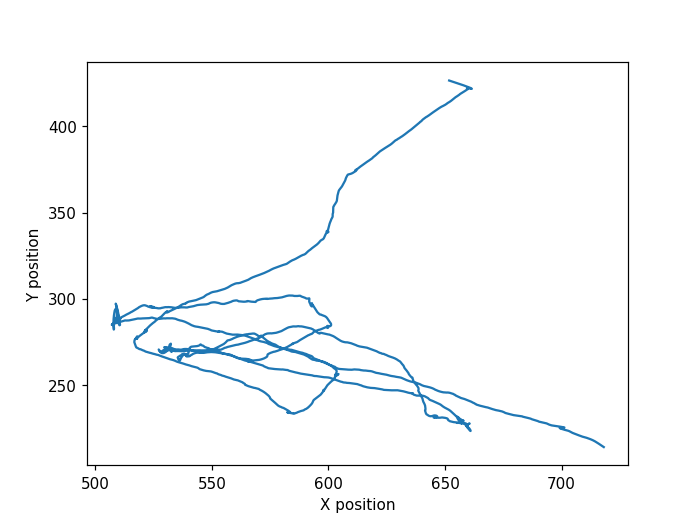

Text(0, 0.5, 'Y position')

In [9]:
fig,ax = plt.subplots()
ax.plot(tails_x[0,:], tails_y[0,:])
ax.set_xlabel('X position')
ax.set_ylabel('Y position')

## Calculate Tailspeed

Next, the tailspeed is calculated

# Warning - make sure to have correct head/tail classification

In [10]:
def calculate_speed(x_filt, y_filt, pixel_per_mm, framerate):
    """
    Calculate Speed of animal. Make sure to use filtered data, for
    example by using the :filter_data: function to smoothen the data.

    Adapted from motion.m from the SOS publication: https://doi.org/10.1371/journal.pone.0041642

    First, distance is calculated over the previous and the next frame.
    dx = x_i-1 - x_i+1
    dy = y_i-1 - y_i+1
    Eucledian distance is just:
    distance = sqrt(dx^2 + dy^2)
    Then, normalize from pixel to mm by dividing by the px/mm factor
    Next, this is a bit unusual as we are integrating over 3 points instead of 2:
    We have to use the symmetric derivative
    https://en.wikipedia.org/wiki/Symmetric_derivative everything needs to be divided
    by 2
    speed = distance / 2 / framerate
    """
    speed = np.zeros((x_filt.shape[0]))
    speed.fill(np.nan)
    for i_frame in range(2, x_filt.shape[0] - 1):
        dx = (x_filt[i_frame + 1]) - (x_filt[i_frame - 1])
        dy = (y_filt[i_frame + 1]) - (y_filt[i_frame - 1])
        distance = np.sqrt(dx ** 2 + dy ** 2)
        distance /= pixel_per_mm
        speed[i_frame] = distance / (2 / framerate)
    return (speed)

In [11]:
# Make a empty list to drop the calculated tail speed in
tail_speed = []

# Iterate over each experiment
for current_experiment in range(tails_y.shape[0]):
    tail_speed.append(calculate_speed(x_filt=tails_x[current_experiment],
                                      y_filt=tails_y[current_experiment],
                                      pixel_per_mm=px_per_mm_previous,
                                      framerate=framerate))
# Convert list to numpy array
tail_speed = np.array(tail_speed)

<IPython.core.display.Javascript object>


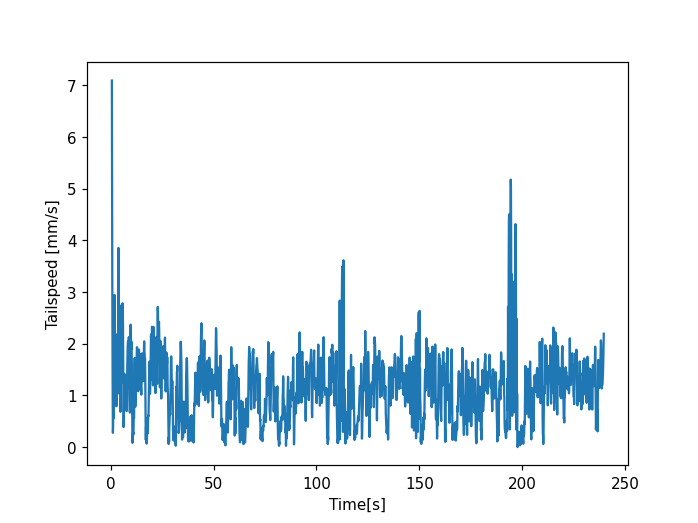

Text(0, 0.5, 'Tailspeed [mm/s]')

In [12]:
fig,ax = plt.subplots()
ax.plot(timestamps[0,:], tail_speed[0,:])
ax.set_xlabel('Time[s]')
ax.set_ylabel('Tailspeed [mm/s]')

## Calculate pulse triggered speed

Note - you must provide the list with the timepoints when the pulses were delivered!!

In [13]:
def calculate_pulse_triggered_speed(data, pulse_index, framerate, time_before, time_after):
    """
    This function takes speed, for example calculated with the
    function :calculate_speed: and a pulse_index provided by the user
    and calculates the speed around the pulse.

    It returns a numpy array with shape (time_after + time_before * framerate, len(pulse_index)).
    Missing data is indicates as NaN in the array.
    """

    # Go from seconds to index
    time_before_index = framerate * time_before
    time_after_index = framerate * time_after


    # Create an empty array to fill
    speed_around_pulse = np.zeros((time_before_index + time_after_index, len(pulse_index)))
    speed_around_pulse.fill(np.nan)

    for counter, current_pulse in enumerate(pulse_index):
        speed_around_pulse[:, counter] = data[current_pulse*framerate - time_before_index:current_pulse*framerate + time_after_index]

    return (speed_around_pulse)

In [14]:
#!!!! Change this to your stimulus protocol!!!!
pulse_indeces = [30, 60, 90, 120, 150, 180, 210] # These are the seconds when the stimulus was presented!

# Choose a time before and after the pulse to be returned
time_before = 5 # seconds
time_after = 5 # seconds

In [15]:
# Make a empty list to drop the calculated tail speed in
pulse_trigged_tailspeed = []

# Iterate over each experiment
for current_experiment in range(tail_speed.shape[0]):
    pulse_trigged_tailspeed.append(calculate_pulse_triggered_speed(data=tail_speed[current_experiment],
                                                                   pulse_index=pulse_indeces,
                                                                   framerate=framerate,
                                                                   time_before=time_before,
                                                                   time_after=time_after))
# convert list to numpy array
pulse_trigged_tailspeed = np.array(pulse_trigged_tailspeed)

### Plot pulse triggered tailspeed for a single experiment

<IPython.core.display.Javascript object>


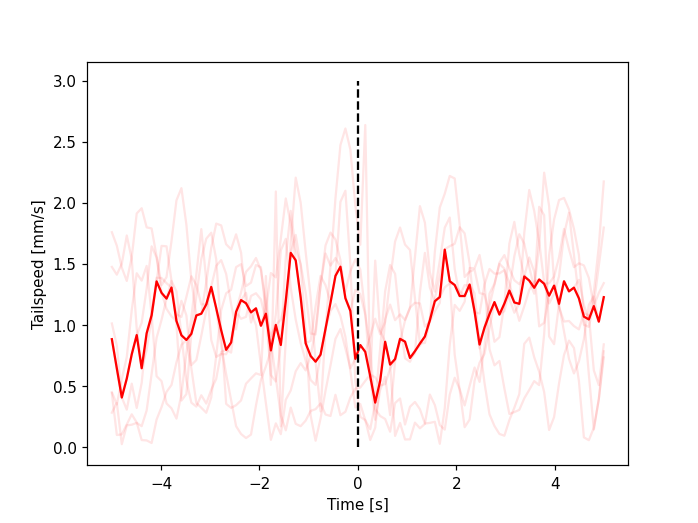

Text(0.5, 0, 'Time [s]')

In [16]:
# Define time for nice plotting on the x axis
time = np.linspace(-time_before, time_after, pulse_trigged_tailspeed.shape[1])
fig,ax=plt.subplots()
# Take median of a single experiment
median_of_each_experiment = np.nanmedian(pulse_trigged_tailspeed,axis=2)
ax.plot(time, median_of_each_experiment[0,:], c='r')

# Plot all trial of a single experiment
ax.plot(time, pulse_trigged_tailspeed[0,:,:],alpha=.1, c='r')

# Indicate pulse
ax.plot([0,0],[0,3], c='k', ls='--')

ax.set_ylabel('Tailspeed [mm/s]')
ax.set_xlabel('Time [s]')

### Plot median for each experiment

<IPython.core.display.Javascript object>


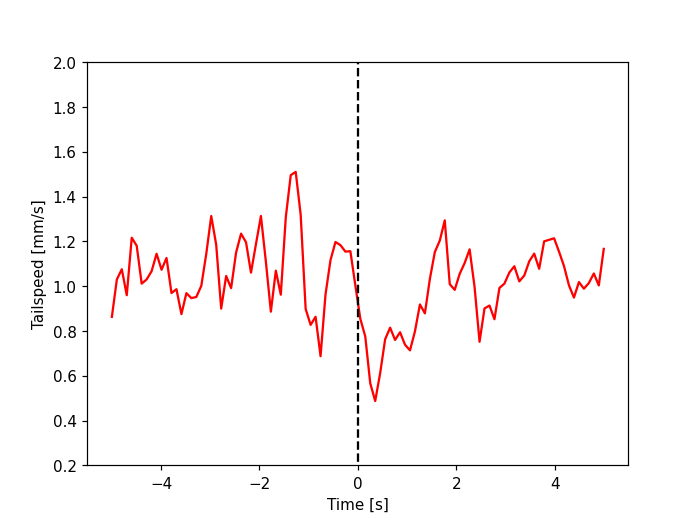

Text(0.5, 0, 'Time [s]')

In [17]:
# Define time for nice plotting on the x axis
time = np.linspace(-time_before, time_after, pulse_trigged_tailspeed.shape[1])
fig,ax=plt.subplots()
# Take median of a single experiment
median_of_all_experiments = np.nanmedian(median_of_each_experiment,axis=0)
ax.plot(time, np.nanmedian(pulse_trigged_tailspeed,axis=(0,2)), c='r')

# before taking mean of all experiments!

# Indicate pulse
ax.plot([0,0],[0,3], c='k', ls='--')

# Limit how much of y is plotted 
ax.set_ylim(0.2,2) # change to accomodate your data
ax.set_ylabel('Tailspeed [mm/s]')
ax.set_xlabel('Time [s]')

### Compare speed before and after pulse

Define the time you want to use before and after the pulse

<IPython.core.display.Javascript object>


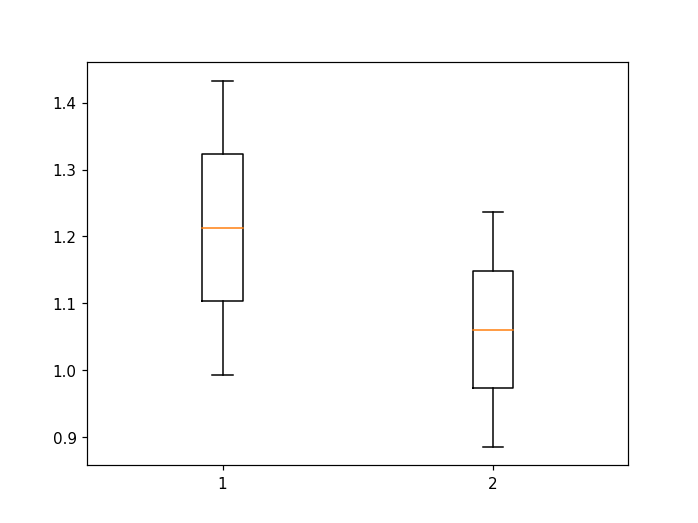

{'whiskers': [<matplotlib.lines.Line2D at 0x2d10adfdf90>,
 'caps': [<matplotlib.lines.Line2D at 0x2d10ae48b50>,
 'boxes': [<matplotlib.lines.Line2D at 0x2d10ae1c050>,
 'medians': [<matplotlib.lines.Line2D at 0x2d10ae4a010>,
 'fliers': [<matplotlib.lines.Line2D at 0x2d1078481d0>,
 'means': []}

In [19]:
time_before_pulse = 2 # seconds # Change as desired 
time_after_pulse = 2 # seconds # Change as desired

###################
# the pulse is in the center
pulse_at_index = median_of_each_experiment.shape[1]/2
# Calculate the speed before and after the pulse
speed_before_pulse = median_of_each_experiment[:,int(pulse_at_index-time_before_pulse*framerate)]
speed_after_pulse = median_of_each_experiment[:,int(pulse_at_index+time_after_pulse*framerate)]
# plot the speed before and after the pulse.
fig,ax=plt.subplots()
ax.boxplot([speed_before_pulse, speed_after_pulse])